## Import data

In [465]:
import pandas as pd # pyright: ignore[reportMissingModuleSource]

df = pd.read_csv("data3.csv", sep=";")
print(df.shape)  # dimensions
print(df.info())  # types and missing values
print(df.head())  # 5 first lines

emg_cols = ['EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8']

(9369, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9369 entries, 0 to 9368
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Email       9369 non-null   object
 1   EMG1        9369 non-null   int64 
 2   EMG2        9369 non-null   int64 
 3   EMG3        9369 non-null   int64 
 4   EMG4        9369 non-null   int64 
 5   EMG5        9369 non-null   int64 
 6   EMG6        9369 non-null   int64 
 7   EMG7        9369 non-null   int64 
 8   EMG8        9369 non-null   int64 
 9   Framecount  9369 non-null   int64 
 10  gesture     9369 non-null   object
 11  SessionID   9369 non-null   object
 12  Timestamp   9369 non-null   object
dtypes: int64(9), object(4)
memory usage: 951.7+ KB
None
       Email  EMG1  EMG2  EMG3  EMG4  EMG5  EMG6  EMG7  EMG8  Framecount  \
0  anonymous   -22   -11   -25   -59    44    29   -39    -2           2   
1  anonymous     5     8    18   104    21    40    92     8           2 

## Clean data
### Manage missing data

In [466]:
df = df.drop_duplicates()  # remove duplicate rows


# remove rows with missing values
df = df.dropna()

# Or fill missing numeric values with column mean
for col in emg_cols:
    df[col] = df[col].fillna(df[col].mean())


### Prepare data

In [467]:
from sklearn.preprocessing import LabelEncoder, StandardScaler # pyright: ignore[reportMissingModuleSource]


# Detect outliers using Inter Quartile Range (IQR)
for col in emg_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]

# Standardization
scaler = StandardScaler()
df[emg_cols] = scaler.fit_transform(df[emg_cols])

print("Standardized EMG columns:")
print(df[emg_cols].head())

# Label Encoding
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['gesture'])
print("\nEncoded labels:")
print(df[['label', 'gesture']].drop_duplicates())

# df = df[df['gesture'] != 'pin'] # TODO: remove

Standardized EMG columns:
         EMG1      EMG2      EMG3      EMG4      EMG5      EMG6      EMG7  \
12  -2.661577 -1.730797 -0.752828  2.296887  0.136065  0.717139 -1.727640   
23  -0.002880  1.333637 -1.745454 -0.455405  1.195864  1.688325 -1.727640   
25   0.587942 -1.390304 -0.091077  0.111243 -0.198608 -1.279187  1.437559   
95   0.587942 -1.049812 -2.241767  0.030294  0.136065  0.069682  2.914652   
112 -0.298291 -1.390304 -0.504671 -1.507752 -0.031271  0.285501  2.914652   

         EMG8  
12   0.630290  
23  -0.308893  
25   0.943351  
95  -0.935014  
112 -0.621954  

Encoded labels:
      label gesture
12        2    open
1804      0   close
4017      3     pin
6928      1    down


### Split data

In [468]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Use the cleaned and prepared dataframe from previous cells
# Separate features (X) and labels (y)
X = df[emg_cols]
y = df['label']

# 3. Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Baseline model
### Search best hyperparameter

In [469]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define model
search_model = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    "max_depth": [2, 4, 6, 8, 10, None],
    "criterion": ["gini", "entropy"]
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(search_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best validation accuracy:", grid_search.best_score_)


Best parameters: {'criterion': 'gini', 'max_depth': 10}
Best validation accuracy: 0.6202505110703024


### Train model

In [470]:
# 4. Train a simple Decision Tree
model = DecisionTreeClassifier(random_state=42, criterion=grid_search.best_params_["criterion"], max_depth=grid_search.best_params_["max_depth"])
model.fit(X_train, y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Evaluation

Validation accuracy: 0.6133122028526149
              precision    recall  f1-score   support

           0       0.60      0.74      0.67       275
           1       0.30      0.19      0.23        16
           2       0.42      0.30      0.35        43
           3       0.66      0.56      0.61       297

    accuracy                           0.61       631
   macro avg       0.50      0.45      0.46       631
weighted avg       0.61      0.61      0.61       631

Cross-validation scores: [0.56692913 0.52380952 0.55555556 0.55555556 0.62698413]
Mean accuracy: 0.565766779152606


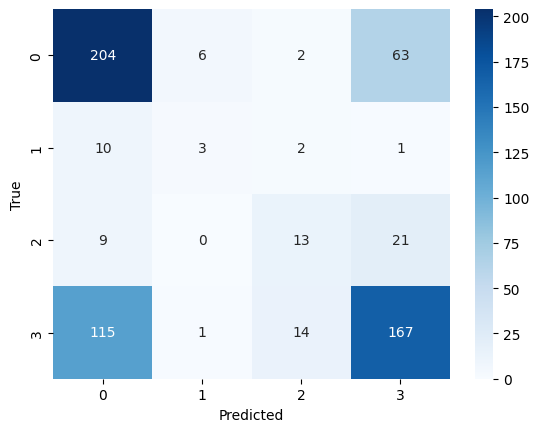

[[0.71779141 0.01226994 0.00613497 0.26380368]
 [0.59090909 0.         0.01136364 0.39772727]
 [0.41428571 0.         0.         0.58571429]
 [0.52963671 0.01720841 0.00956023 0.44359465]
 [0.0862069  0.         0.01724138 0.89655172]]


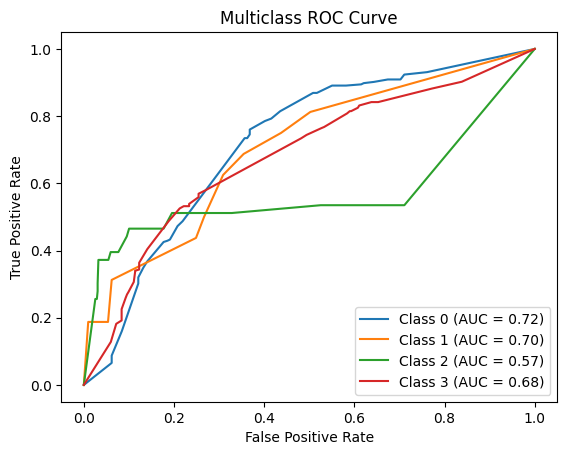

In [471]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_val, y_val):
    # Evaluate on validation set
    y_pred = model.predict(X_val)
    print("Validation accuracy:", accuracy_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
	
    # Cross-validation
    scores = cross_val_score(model, X_val, y_val, cv=5)
    print("Cross-validation scores:", scores)
    print("Mean accuracy:", scores.mean())


    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


    # Predict probabilities for the first 5 samples in the validation set
    probs = model.predict_proba(X_val[:5])
    print(probs)


    # ROC Curve
    y_val_bin = label_binarize(y_val, classes=model.classes_)
    probs_full = model.predict_proba(X_val)

    plt.figure()
    for i in range(y_val_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], probs_full[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend()
    plt.show()

evaluate_model(model, X_val, y_val)


## Artificial Neural Network

Class weights: {np.int64(0): np.float64(0.5772549019607843), np.int64(1): np.float64(10.823529411764707), np.int64(2): np.float64(4.355029585798817), np.int64(3): np.float64(0.5139664804469274)}
Training improved neural network...
Training completed!
Number of iterations: 93
Final loss: 0.2725

=== IMPROVED NEURAL NETWORK RESULTS ===
Validation accuracy: 0.7210776545166403
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       275
           1       0.62      0.31      0.42        16
           2       0.69      0.58      0.63        43
           3       0.74      0.70      0.72       297

    accuracy                           0.72       631
   macro avg       0.69      0.60      0.63       631
weighted avg       0.72      0.72      0.72       631

Cross-validation scores: [0.66929134 0.66666667 0.66666667 0.63492063 0.67460317]
Mean accuracy: 0.662429696287964


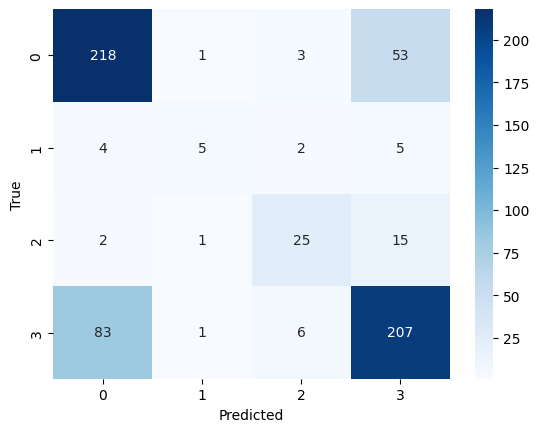

[[8.69386823e-01 1.23363260e-04 9.23897607e-04 1.29565916e-01]
 [7.92635604e-01 4.36297745e-04 2.55063272e-04 2.06673035e-01]
 [4.69465718e-01 1.93096930e-03 2.06722467e-03 5.26536088e-01]
 [5.51687332e-01 5.62707203e-04 1.44448466e-04 4.47605512e-01]
 [8.09131944e-03 3.44703626e-04 1.72089004e-03 9.89843087e-01]]


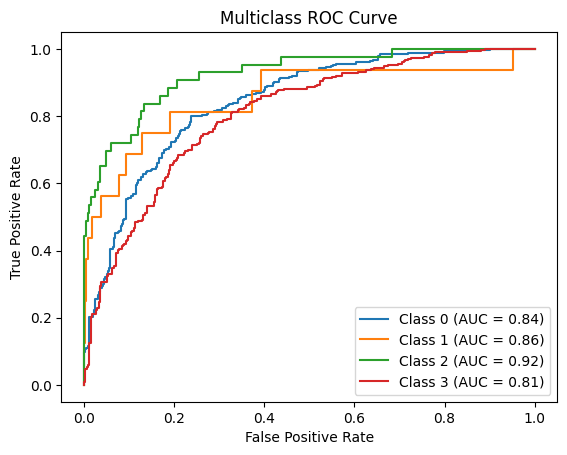

In [472]:
## Improved Neural Network Architecture

from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to handle imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

# Improved neural network with more layers and regularization
mlp_improved = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32, 16),  # Deeper network with more neurons
    activation='relu',
    solver='adam',
    alpha=0.001,                          # L2 regularization
    learning_rate_init=0.001,             # Lower learning rate
    max_iter=5000,
    early_stopping=True,                  # Stop when validation score stops improving
    validation_fraction=0.2,              # Use 20% of training data for validation
    n_iter_no_change=50,                 # Stop after 50 iterations without improvement
    random_state=42,
    batch_size='auto'
)

print("Training improved neural network...")
mlp_improved.fit(X_train, y_train)

print("Training completed!")
print(f"Number of iterations: {mlp_improved.n_iter_}")
print(f"Final loss: {mlp_improved.loss_:.4f}")

# Evaluate the improved model
print("\n=== IMPROVED NEURAL NETWORK RESULTS ===")
evaluate_model(mlp_improved, X_val, y_val)

In [473]:
## Feature Engineering for EMG Signals

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA

def extract_emg_features(data):
    """Extract advanced features from EMG signals"""
    features = []
    
    for col in emg_cols:
        signal = data[col].values
        
        # Time domain features
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        rms = np.sqrt(np.mean(signal**2))  # Root Mean Square
        variance = np.var(signal)
        skewness = stats.skew(signal)
        kurtosis = stats.kurtosis(signal)
        
        # Statistical features
        percentile_25 = np.percentile(signal, 25)
        percentile_75 = np.percentile(signal, 75)
        median = np.median(signal)
        range_val = np.max(signal) - np.min(signal)
        
        # Add features for this channel
        features.extend([mean_val, std_val, rms, variance, skewness, kurtosis,
                        percentile_25, percentile_75, median, range_val])
    
    return np.array(features)

# Create enhanced feature matrix
print("Extracting advanced EMG features...")

# Group by session and gesture for temporal features
X_enhanced_list = []
y_enhanced_list = []

for session_id in df['SessionID'].unique():
    session_data = df[df['SessionID'] == session_id]
    
    for gesture in session_data['gesture'].unique():
        gesture_data = session_data[session_data['gesture'] == gesture]
        
        if len(gesture_data) >= 10:  # Minimum samples for feature extraction
            features = extract_emg_features(gesture_data)
            X_enhanced_list.append(features)
            y_enhanced_list.append(gesture_data['label'].iloc[0])

X_enhanced = np.array(X_enhanced_list)
y_enhanced = np.array(y_enhanced_list)

print(f"Enhanced feature matrix shape: {X_enhanced.shape}")
print(f"Number of features per sample: {X_enhanced.shape[1]}")

# Standardize enhanced features
scaler_enhanced = StandardScaler()
X_enhanced_scaled = scaler_enhanced.fit_transform(X_enhanced)

# Split enhanced dataset
X_enh_train, X_enh_temp, y_enh_train, y_enh_temp = train_test_split(
    X_enhanced_scaled, y_enhanced, test_size=0.3, random_state=42, stratify=y_enhanced
)
X_enh_val, X_enh_test, y_enh_val, y_enh_test = train_test_split(
    X_enh_temp, y_enh_temp, test_size=0.5, random_state=42, stratify=y_enh_temp
)

print(f"Enhanced training set: {X_enh_train.shape}")
print(f"Enhanced validation set: {X_enh_val.shape}")
print(f"Enhanced test set: {X_enh_test.shape}")

# Train model with enhanced features
mlp_enhanced = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate_init=0.001,
    max_iter=5000,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=100,
    random_state=42
)

print("\nTraining neural network with enhanced features...")
mlp_enhanced.fit(X_enh_train, y_enh_train)

print("\n=== ENHANCED FEATURES NEURAL NETWORK RESULTS ===")
evaluate_model(mlp_enhanced, X_enh_val, y_enh_val)

Extracting advanced EMG features...
Enhanced feature matrix shape: (4, 80)
Number of features per sample: 80


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [ ]:
## Advanced Models and Ensemble Methods

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import time

# 1. Random Forest (good for feature importance)
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# 2. SVM with RBF kernel
svm = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    class_weight='balanced',
    probability=True,  # Needed for voting classifier
    random_state=42
)

# 3. Optimized Neural Network
mlp_final = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32, 16),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.0005,
    max_iter=3000,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=50,
    random_state=42
)

print("Training individual models...")

# Train all models
models = {
    'Random Forest': rf,
    'SVM': svm,
    'Neural Network': mlp_final
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    
    if X_enhanced_scaled.shape[0] > 0:  # Use enhanced features if available
        model.fit(X_enh_train, y_enh_train)
        y_pred = model.predict(X_enh_val)
        accuracy = accuracy_score(y_enh_val, y_pred)
    else:  # Fallback to original features
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
    
    training_time = time.time() - start_time
    results[name] = {'accuracy': accuracy, 'time': training_time}
    print(f"{name} - Accuracy: {accuracy:.4f}, Time: {training_time:.2f}s")

# 4. Ensemble Voting Classifier
print("\nCreating ensemble model...")
ensemble = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('svm', svm),
        ('mlp', mlp_final)
    ],
    voting='soft'  # Use predicted probabilities
)

if X_enhanced_scaled.shape[0] > 0:
    ensemble.fit(X_enh_train, y_enh_train)
    print("\n=== ENSEMBLE MODEL RESULTS (Enhanced Features) ===")
    evaluate_model(ensemble, X_enh_val, y_enh_val)
else:
    ensemble.fit(X_train, y_train)
    print("\n=== ENSEMBLE MODEL RESULTS ===")
    evaluate_model(ensemble, X_val, y_val)

# Feature importance from Random Forest
if hasattr(rf, 'feature_importances_'):
    print("\n=== TOP 10 MOST IMPORTANT FEATURES ===")
    if X_enhanced_scaled.shape[0] > 0:
        feature_names = [f"Feature_{i}" for i in range(X_enhanced.shape[1])]
    else:
        feature_names = emg_cols
    
    importance_pairs = list(zip(feature_names, rf.feature_importances_))
    importance_pairs.sort(key=lambda x: x[1], reverse=True)
    
    for i, (feature, importance) in enumerate(importance_pairs[:10]):
        print(f"{i+1:2d}. {feature:15s}: {importance:.4f}")

print("\n=== SUMMARY OF ALL MODELS ===")
for name, result in results.items():
    print(f"{name:15s}: {result['accuracy']:.4f} accuracy ({result['time']:.2f}s)")

In [ ]:
## Data Analysis and Diagnostics

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Analyze class distribution
print("=== CLASS DISTRIBUTION ANALYSIS ===")
class_counts = df['gesture'].value_counts()
print("Original dataset:")
for gesture, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{gesture:10s}: {count:4d} samples ({percentage:5.1f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Gesture')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)

# 2. Analyze EMG signal characteristics by gesture
plt.subplot(1, 2, 2)
for gesture in df['gesture'].unique():
    gesture_data = df[df['gesture'] == gesture]
    mean_emg = gesture_data[emg_cols].mean().mean()
    std_emg = gesture_data[emg_cols].std().mean()
    plt.scatter(mean_emg, std_emg, label=gesture, s=100)

plt.xlabel('Mean EMG Signal')
plt.ylabel('Standard Deviation')
plt.title('EMG Signal Characteristics by Gesture')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Correlation matrix of EMG channels
plt.figure(figsize=(10, 8))
correlation_matrix = df[emg_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('EMG Channels Correlation Matrix')
plt.show()

# 4. Signal quality analysis
print("\n=== SIGNAL QUALITY ANALYSIS ===")
for col in emg_cols:
    signal_range = df[col].max() - df[col].min()
    signal_std = df[col].std()
    snr_estimate = abs(df[col].mean()) / signal_std if signal_std > 0 else 0
    print(f"{col}: Range={signal_range:6.1f}, STD={signal_std:6.2f}, SNR≈{snr_estimate:.2f}")

# 5. Learning curve analysis (if you want to run this)
def plot_learning_curve(model, X, y, title="Learning Curve"):
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training accuracy')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation accuracy')
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
    plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                     np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n=== RECOMMENDATIONS FOR IMPROVEMENT ===")
print("1. 📊 COLLECT MORE DATA for underrepresented classes")
print("2. 🔄 USE DATA AUGMENTATION (add noise, time shifting)")
print("3. ⚡ TRY TEMPORAL FEATURES (RNN/LSTM for sequence data)")
print("4. 🎯 OPTIMIZE HYPERPARAMETERS with GridSearchCV")
print("5. 🧪 EXPERIMENT with different preprocessing (filters, normalization)")
print("6. 📈 USE EARLY STOPPING to prevent overfitting")
print("7. 🔍 ANALYZE MISCLASSIFIED SAMPLES for insights")

Validation accuracy: 0.6988906497622821
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       275
           1       0.50      0.38      0.43        16
           2       0.67      0.47      0.55        43
           3       0.70      0.70      0.70       297

    accuracy                           0.70       631
   macro avg       0.64      0.57      0.60       631
weighted avg       0.70      0.70      0.70       631

Cross-validation scores: [0.60629921 0.64285714 0.56349206 0.61904762 0.70634921]
Mean accuracy: 0.6276090488688915


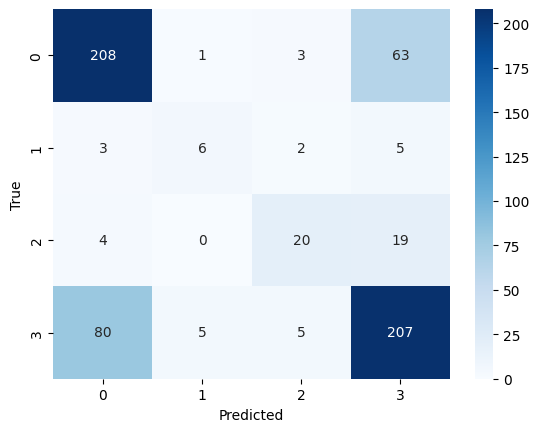

[[7.40269987e-01 2.20071159e-05 1.22273101e-03 2.58485275e-01]
 [7.88429046e-01 1.21245958e-03 1.89098526e-03 2.08467509e-01]
 [3.99136738e-01 1.62969052e-03 6.89116319e-03 5.92342408e-01]
 [5.58898157e-01 1.20189927e-03 8.09576300e-04 4.39090368e-01]
 [1.36306824e-02 2.06549882e-04 3.52412409e-02 9.50921527e-01]]


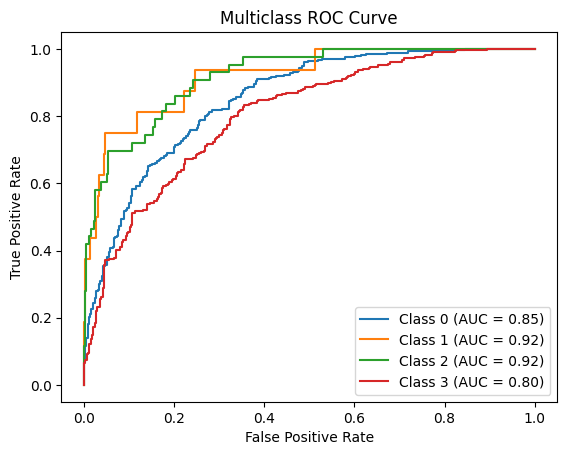

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Define a simple neural network
mlp = MLPClassifier(
    hidden_layer_sizes=(16, 8),  # 2 hidden layers: 16 neurons then 8 neurons
    activation='relu',           # Activation function
    solver='adam',               # Optimizer
    max_iter=3000,               # Maximum number of iterations
    random_state=42
)

# Train the model
mlp.fit(X_train, y_train)

# Predict
y_pred = mlp.predict(X_test)

# Evaluate
evaluate_model(mlp, X_val, y_val)